# SquirrelXAI: Photorealistic Inpainting for Explainability

This notebook demonstrates the complete pipeline for generating perturbation-based explanations using object detection and inpainting.


## Setup and Imports


In [ ]:
import os
import json
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Add current directory to path
sys.path.append(".")

# Import our modules
from detect import detect_squirrels
from generate_masks import generate_masks_from_detections
from inpaint import batch_inpaint, test_backend
from perturbation_analysis import analyze_perturbations
from visualize import generate_all_visualizations

print("Setup complete!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/tusunaiturumbekova/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup complete!


In [4]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print(
    "MPS (Mac GPU) available:",
    torch.backends.mps.is_available() if hasattr(torch.backends, "mps") else False,
)
print(
    "MPS built:",
    torch.backends.mps.is_built() if hasattr(torch.backends, "mps") else False,
)

# Determine best device
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"\n✓ Using device: {device}")

PyTorch version: 2.6.0
CUDA available: False
MPS (Mac GPU) available: True
MPS built: True

✓ Using device: mps


## Configuration


In [ ]:
# Paths configuration
MODEL_PATH = "model/best.pt"
TEST_IMAGES_DIR = "squirrel_data/test/images"
TRAIN_IMAGES_DIR = "squirrel_data/train/images"
VAL_IMAGES_DIR = "squirrel_data/valid/images"

# Shared detection outputs (Stage 1 is common for both methods)
OUTPUTS_DIR = "outputs"
DETECTIONS_DIR = os.path.join(OUTPUTS_DIR, "detections")

# Choose masking method: "bbox" or "sam"
MASKING_METHOD = "sam"  # change to "bbox" to run the bounding-box pipeline

# Tag and method-specific root
METHOD_TAG = "sam" if MASKING_METHOD == "sam" else "bbox"
METHOD_OUTPUT_ROOT = os.path.join(OUTPUTS_DIR, METHOD_TAG)

# Method-specific output directories
MASKS_DIR = os.path.join(METHOD_OUTPUT_ROOT, "masks")
INPAINTED_DIR = os.path.join(METHOD_OUTPUT_ROOT, "inpainted")
ANALYSIS_DIR = os.path.join(METHOD_OUTPUT_ROOT, "analysis")
VISUALS_DIR = os.path.join(METHOD_OUTPUT_ROOT, "final_visuals")

# Create output directories
for dir_path in [DETECTIONS_DIR, MASKS_DIR, INPAINTED_DIR, ANALYSIS_DIR, VISUALS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print(f"Configuration loaded! Using masking method: {MASKING_METHOD}")
print(f"Method-specific outputs will be stored in: {METHOD_OUTPUT_ROOT}")

Configuration loaded! Using masking method: sam
Method-specific outputs will be stored in: outputs/sam


## Stage 1: YOLOv9 Detection

Detect squirrels in test images using the trained YOLOv9 model.


In [6]:
print("Stage 1: Running YOLOv9 detection...")
detections = detect_squirrels(
    model_path=MODEL_PATH,
    images_dir=TEST_IMAGES_DIR,
    output_dir=DETECTIONS_DIR,
    conf_threshold=0.25,
)

print(f"\nDetected squirrels in {len(detections)} images")
total_detections = sum(r["num_detections"] for r in detections.values())
print(f"Total detections: {total_detections}")

Stage 1: Running YOLOv9 detection...
Loading YOLOv9 model from model/best.pt...
Found 64 images to process


Detecting squirrels: 100%|██████████| 64/64 [00:18<00:00,  3.44it/s]


Detection complete! Results saved to outputs/detections/detections.json
Total images processed: 64
Total detections: 79

Detected squirrels in 64 images
Total detections: 79


### Save detection images

In [7]:
from ultralytics import YOLO
import os

model_path = "model/best.pt"
model = YOLO(model_path)
import os

# Path to test images
test_img_dir = "squirrel_data/test/images"

# Loop through and predict
for file in os.listdir(test_img_dir):
    if file.endswith((".jpg", ".png")):
        image_path = os.path.join(test_img_dir, file)
        results = model.predict(image_path, save=True, conf=0.25)


image 1/1 /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/squirrel_data/test/images/9d807b0f20e78202_jpg.rf.87f986d3258c2d11d67293730ff18dec.jpg: 640x640 1 Squirrel, 278.0ms
Speed: 0.8ms preprocess, 278.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/runs/detect/predict2

image 1/1 /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/squirrel_data/test/images/s_321_jpg.rf.492bbea7376b5b83a65bfddb6613b992.jpg: 640x640 1 Squirrel, 304.4ms
Speed: 0.9ms preprocess, 304.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object-Level-Model-Explanations/runs/detect/predict2

image 1/1 /Users/tusunaiturumbekova/SquirrelXAI-Photorealistic-Inpainting-for-Object

### Let's see one example

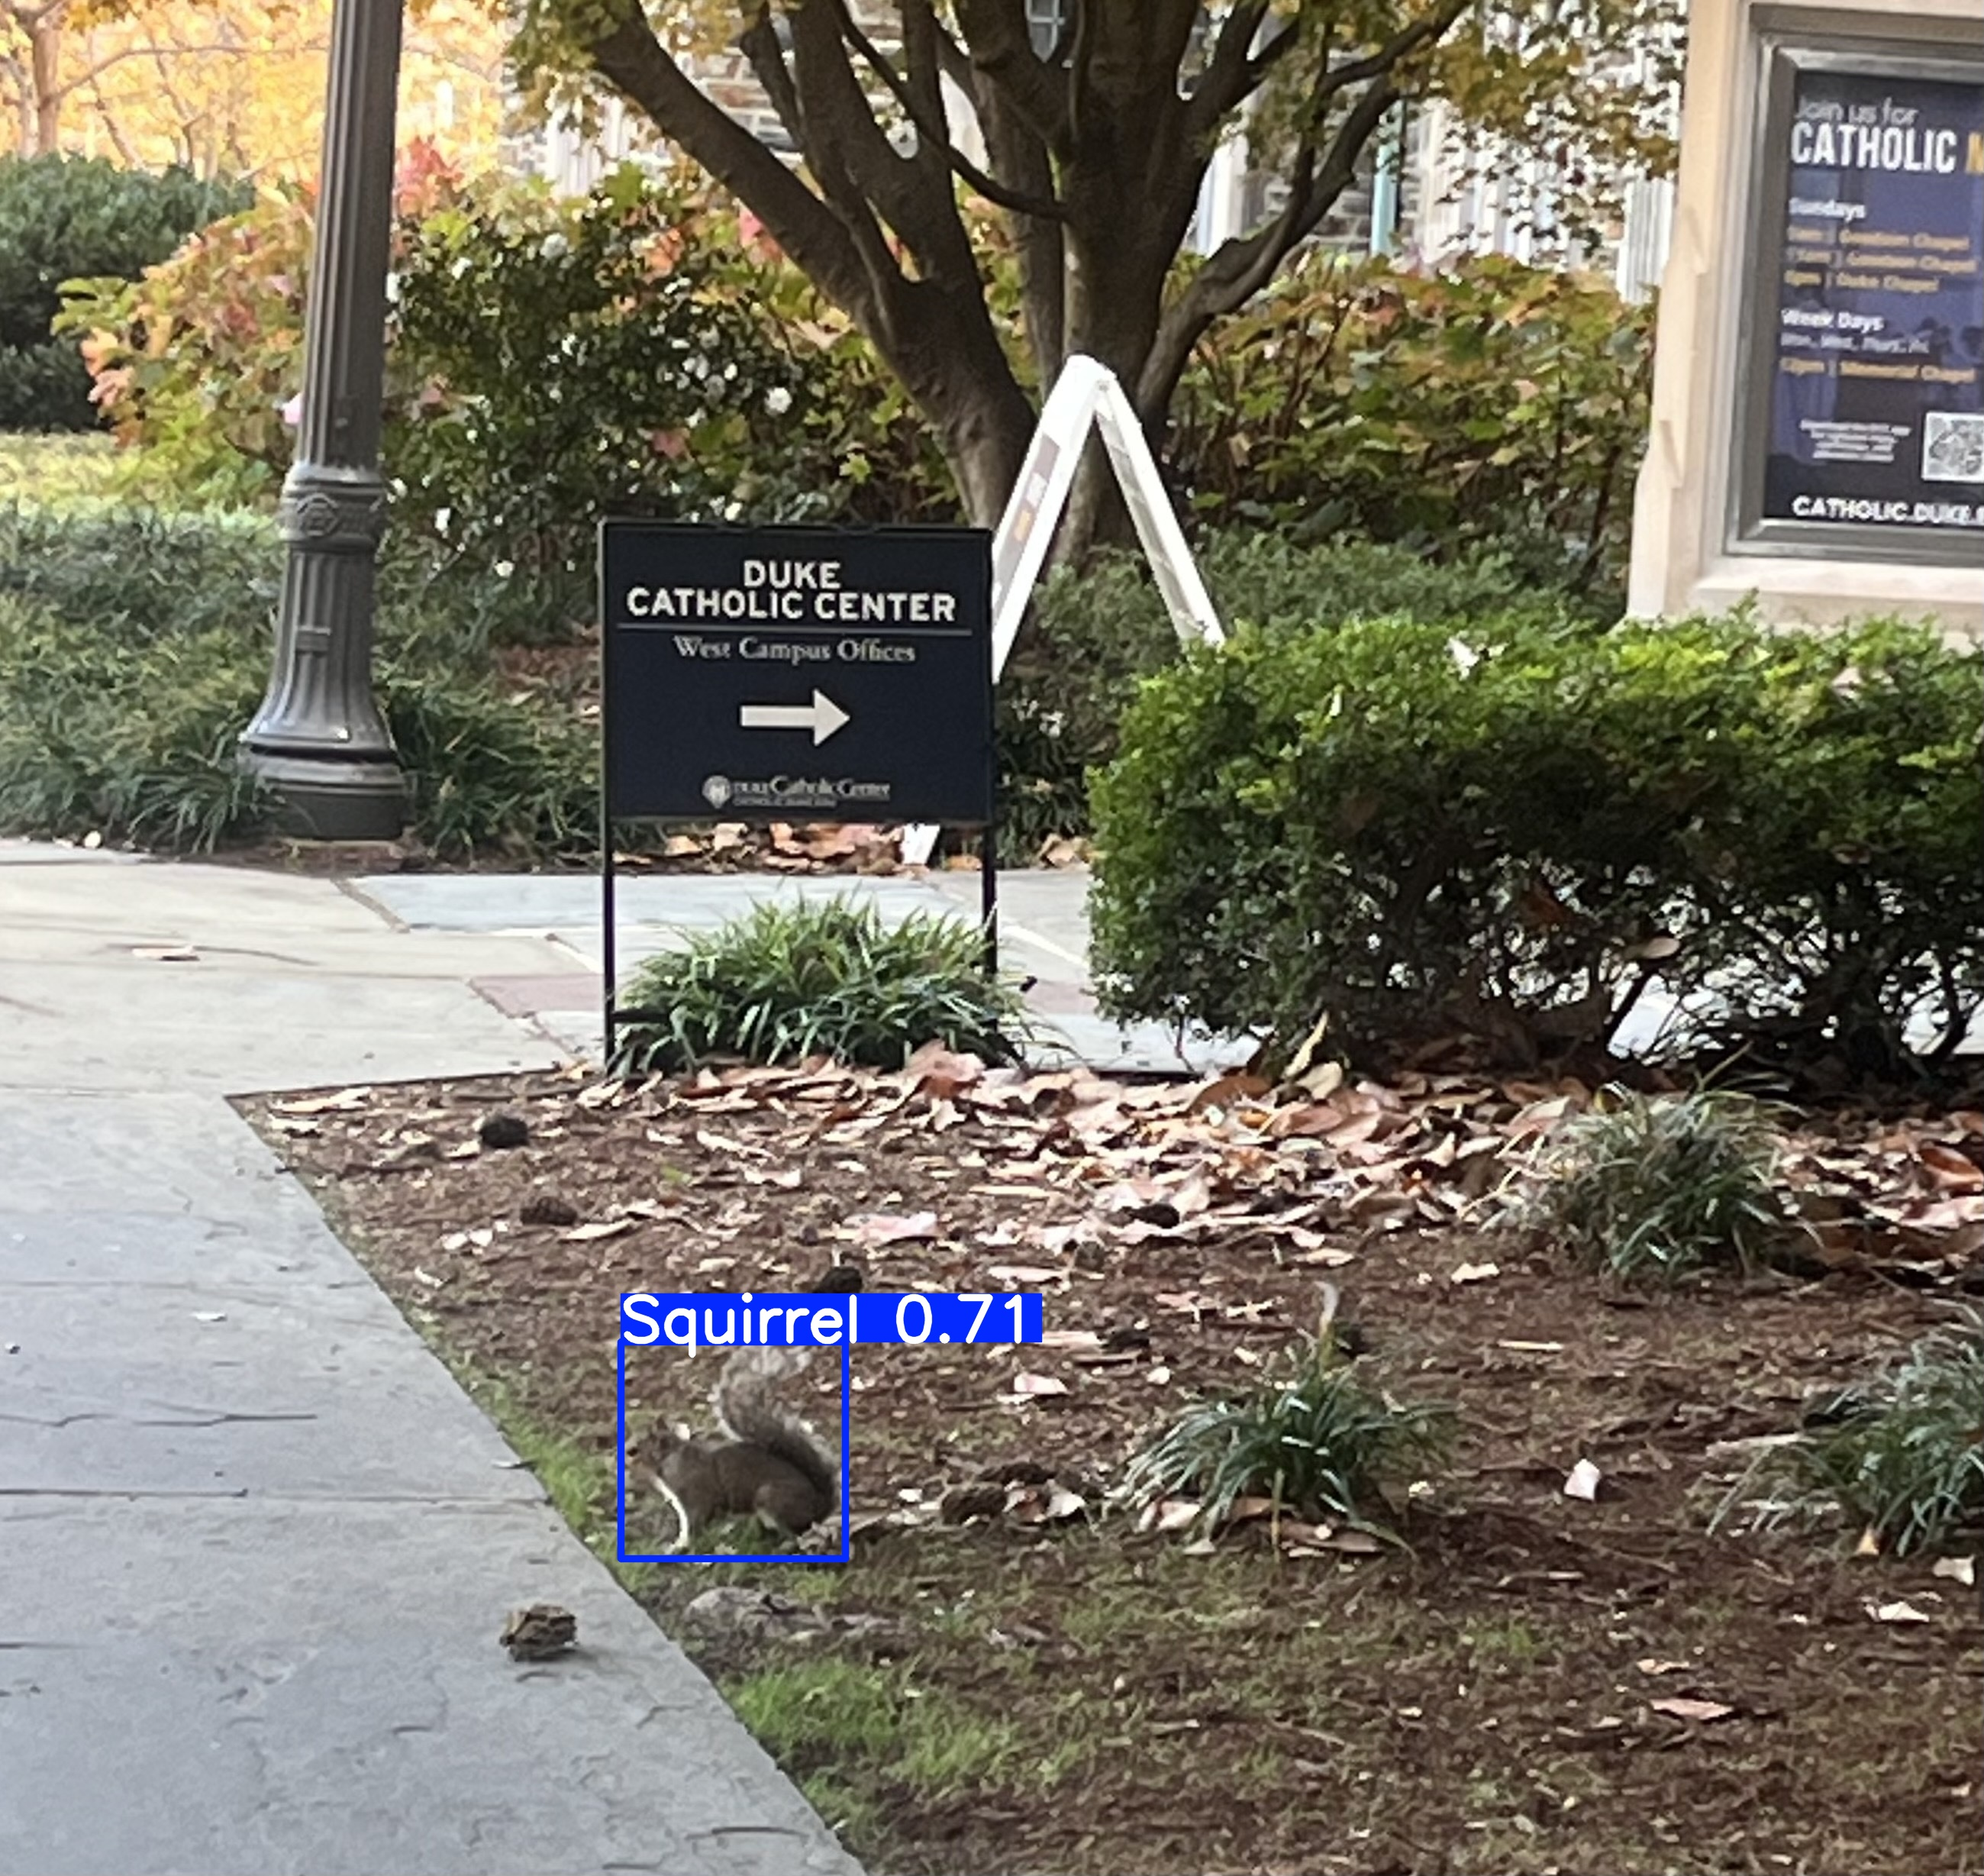

In [8]:
from IPython.display import Image, display

# Show one of the predicted images
result_img_path = "runs/detect/predict/Duke3.jpg"  # Adjust filename
display(Image(filename=result_img_path))

## Stage 2: Mask Generation

Generate segmentation masks from bounding boxes or SAM. Optionally use existing masks if available.


In [ ]:
print("Stage 2: Generating masks...")

detections_json = os.path.join(DETECTIONS_DIR, "detections.json")

if MASKING_METHOD == "bbox":
    print("→ Using bounding-box masks")
    mask_paths = generate_masks_from_detections(
        detections_json=detections_json,
        images_dir=TEST_IMAGES_DIR,
        output_dir=MASKS_DIR,
        use_existing_masks=None,  # pure bbox-based masks
        use_sam=False,
    )

elif MASKING_METHOD == "sam":
    print("→ Using SAM-based segmentation masks")
    mask_paths = generate_masks_from_detections(
        detections_json=detections_json,
        images_dir=TEST_IMAGES_DIR,
        output_dir=MASKS_DIR,
        use_existing_masks=None,  # do NOT use masks2
        use_sam=True,
        sam_checkpoint="sam/sam_vit_b.pth",  # or sam_vit_b_01ec64.pth
        sam_model_type="vit_b",
    )

else:
    raise ValueError("MASKING_METHOD must be 'bbox' or 'sam'")

print(f"\nGenerated {len(mask_paths)} masks using method: {MASKING_METHOD}")
print(f"Masks saved to: {MASKS_DIR}")

Stage 2: Generating masks...
→ Using SAM-based segmentation masks
[SAM] Loading model 'vit_b' on device: mps


Generating masks: 100%|██████████| 64/64 [01:12<00:00,  1.14s/it]


Mask generation complete! Masks saved to outputs/sam/masks
Total masks generated: 64

Generated 64 masks using method: sam
Masks saved to: outputs/sam/masks


## Stage 3: Inpainting

Perform inpainting using Stable Diffusion via Replicate API. First, we test the backend.


In [ ]:
import os

os.environ["REPLICATE_API_TOKEN"] = "token"  # Replace with your token
print("✓ API token set")

✓ API token set


In [11]:
print("Stage 3: Testing inpainting backend...")

# Get a sample image and mask for testing
sample_images = [f for f in os.listdir(TEST_IMAGES_DIR) if f.endswith(".jpg")]
if sample_images:
    test_image = os.path.join(TEST_IMAGES_DIR, sample_images[0])
    test_mask = os.path.join(
        MASKS_DIR, sample_images[0].rsplit(".", 1)[0] + "_mask.png"
    )

    if os.path.exists(test_mask):
        test_backend(
            test_image_path=test_image,
            test_mask_path=test_mask,
            output_dir=os.path.join(METHOD_OUTPUT_ROOT, "backend_tests"),
            backend_name="stable_diffusion",
        )
    else:
        print(f"Test mask not found: {test_mask}")
else:
    print("No test images found")

Stage 3: Testing inpainting backend...

Testing stable_diffusion backend...
Test image: squirrel_data/test/images/9d807b0f20e78202_jpg.rf.87f986d3258c2d11d67293730ff18dec.jpg
Test mask: outputs/sam/masks/9d807b0f20e78202_jpg.rf.87f986d3258c2d11d67293730ff18dec_mask.png
Running inpainting...
Verifying output...
✓ Backend test passed! Output saved to outputs/sam/backend_tests/test_output_stable_diffusion.jpg


In [12]:
print("Stage 3: Running batch inpainting...")
print("Note: This may take a while due to API rate limits.")
print(
    "Using 12 second delay between requests to respect rate limits (6 req/min for <$5 accounts)"
)

mask_paths_json = os.path.join(MASKS_DIR, "mask_paths.json")

inpainted_paths = batch_inpaint(
    mask_paths_json=mask_paths_json,
    images_dir=TEST_IMAGES_DIR,
    output_dir=INPAINTED_DIR,
    backend="stable_diffusion",
    prompt="seamless natural background, consistent lighting, no animals",
    negative_prompt="duplicate, distortion, artifacts, low quality",
    delay_between_requests=12.0,
    max_retries=3,
)

print(f"\nInpainted {len(inpainted_paths)} images using masks from: {MASKS_DIR}")
print(f"Inpainted images saved to: {INPAINTED_DIR}")

Stage 3: Running batch inpainting...
Note: This may take a while due to API rate limits.
Using 12 second delay between requests to respect rate limits (6 req/min for <$5 accounts)


Inpainting with stable_diffusion: 100%|██████████| 64/64 [16:12<00:00, 15.19s/it]


Inpainting complete! Results saved to outputs/sam/inpainted/stable_diffusion
Total images inpainted: 64

Inpainted 64 images using masks from: outputs/sam/masks
Inpainted images saved to: outputs/sam/inpainted


## Stage 4: Run Detection Analysis

Run YOLOv9 detection on both original and inpainted images, then compare the results.


In [ ]:
print("Stage 4: Running detection analysis...")

detections_json = os.path.join(DETECTIONS_DIR, "detections.json")
inpainted_paths_json = os.path.join(
    INPAINTED_DIR, "stable_diffusion", "inpainted_paths.json"
)

df, summary = analyze_perturbations(
    detections_json=detections_json,
    original_images_dir=TEST_IMAGES_DIR,
    inpainted_paths_json=inpainted_paths_json,
    yolo_model_path=MODEL_PATH,
    output_dir=ANALYSIS_DIR,
    conf_threshold=0.25,
)

print("\nAnalysis Summary:")
import json

print(json.dumps(summary, indent=2))
print(f"\nAnalysis CSV and summary saved to: {ANALYSIS_DIR}")

Stage 4: Running detection analysis...
Analyzing perturbations using YOLOv9 detection...
Processing 64 image pairs...
Verifying original image detections...


Running YOLO detection: 100%|██████████| 64/64 [00:16<00:00,  3.77it/s]


Running YOLOv9 detection on inpainted images...


Running YOLO detection: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]


Analysis complete! Results saved to outputs/sam/analysis
Mean detection drop: 0.83
Mean detection removal rate: 63.54%
All detections removed: 39/64 (60.94%)
Mean avg confidence drop: 0.4596

Analysis Summary:
{
  "total_images": 64,
  "mean_detection_drop": 0.828125,
  "std_detection_drop": 0.827209643107957,
  "mean_detection_removal_rate": 0.6354166666666667,
  "mean_avg_confidence_drop": 0.4596382232848555,
  "mean_max_confidence_drop": 0.49729916267096996,
  "total_all_removed": 39,
  "FLIP_RATE": 0.609375,
  "total_partial_removal": 6,
  "partial_removal_rate": 0.09375,
  "mean_original_detections": 1.234375,
  "mean_inpainted_detections": 0.40625
}

Analysis CSV and summary saved to: outputs/sam/analysis


## Stage 5: Visualizations

Generate comprehensive visualizations showing original images, detections, masks, inpainted images, and confidence plots.


In [14]:
print("Stage 5: Generating visualizations...")

detections_json = os.path.join(DETECTIONS_DIR, "detections.json")
mask_paths_json = os.path.join(MASKS_DIR, "mask_paths.json")
inpainted_paths_json = os.path.join(
    INPAINTED_DIR, "stable_diffusion", "inpainted_paths.json"
)
analysis_csv = os.path.join(ANALYSIS_DIR, "perturbation_analysis.csv")

generate_all_visualizations(
    detections_json=detections_json,
    mask_paths_json=mask_paths_json,
    inpainted_paths_json=inpainted_paths_json,
    analysis_csv=analysis_csv,
    original_images_dir=TEST_IMAGES_DIR,
    output_dir=VISUALS_DIR,
)

print("\nVisualizations complete!")
print(f"Individual visualizations saved to: {os.path.join(VISUALS_DIR, 'individual')}")
print(f"Summary plots saved to: {VISUALS_DIR}")

Stage 5: Generating visualizations...
Generating visualizations...


Creating visualizations: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s]


Summary plots saved to outputs/sam/final_visuals

All visualizations saved to outputs/sam/final_visuals

Visualizations complete!
Individual visualizations saved to: outputs/sam/final_visuals/individual
Summary plots saved to: outputs/sam/final_visuals


## Results Summary

Display key findings from the explainability analysis.


In [ ]:
import json

summary_path = os.path.join(ANALYSIS_DIR, "summary.json")
with open(summary_path, "r") as f:
    summary = json.load(f)

print("=" * 60)
print(
    f"EXPLAINABILITY ANALYSIS SUMMARY (YOLOv9 Detection) – {MASKING_METHOD.upper()} MASKS"
)
print("=" * 60)
print(f"Total Images Analyzed: {summary['total_images']}")
print(f"\nDetection Metrics:")
print(f"  Mean Detection Drop: {summary['mean_detection_drop']:.2f} detections")
print(f"  Mean Detection Removal Rate: {summary['mean_detection_removal_rate']:.2%}")
print(
    f"  All Detections Removed: {summary['total_all_removed']}/{summary['total_images']} "
    f"({summary['all_removed_rate']:.2%})"
)
print(
    f"  Partial Removal: {summary['total_partial_removal']}/{summary['total_images']} "
    f"({summary['partial_removal_rate']:.2%})"
)
print(f"\nConfidence Metrics:")
print(f"  Mean Avg Confidence Drop: {summary['mean_avg_confidence_drop']:.4f}")
print(f"  Mean Max Confidence Drop: {summary['mean_max_confidence_drop']:.4f}")
print(f"\nAverage Detections:")
print(f"  Original Images: {summary['mean_original_detections']:.2f}")
print(f"  Inpainted Images: {summary['mean_inpainted_detections']:.2f}")
print("=" * 60)
print(f"Results for method '{MASKING_METHOD}' stored in: {METHOD_OUTPUT_ROOT}")

EXPLAINABILITY ANALYSIS SUMMARY (YOLOv9 Detection) – SAM MASKS
Total Images Analyzed: 64

Detection Metrics:
  Mean Detection Drop: 0.83 detections
  Mean Detection Removal Rate: 63.54%


KeyError: 'all_removed_rate'

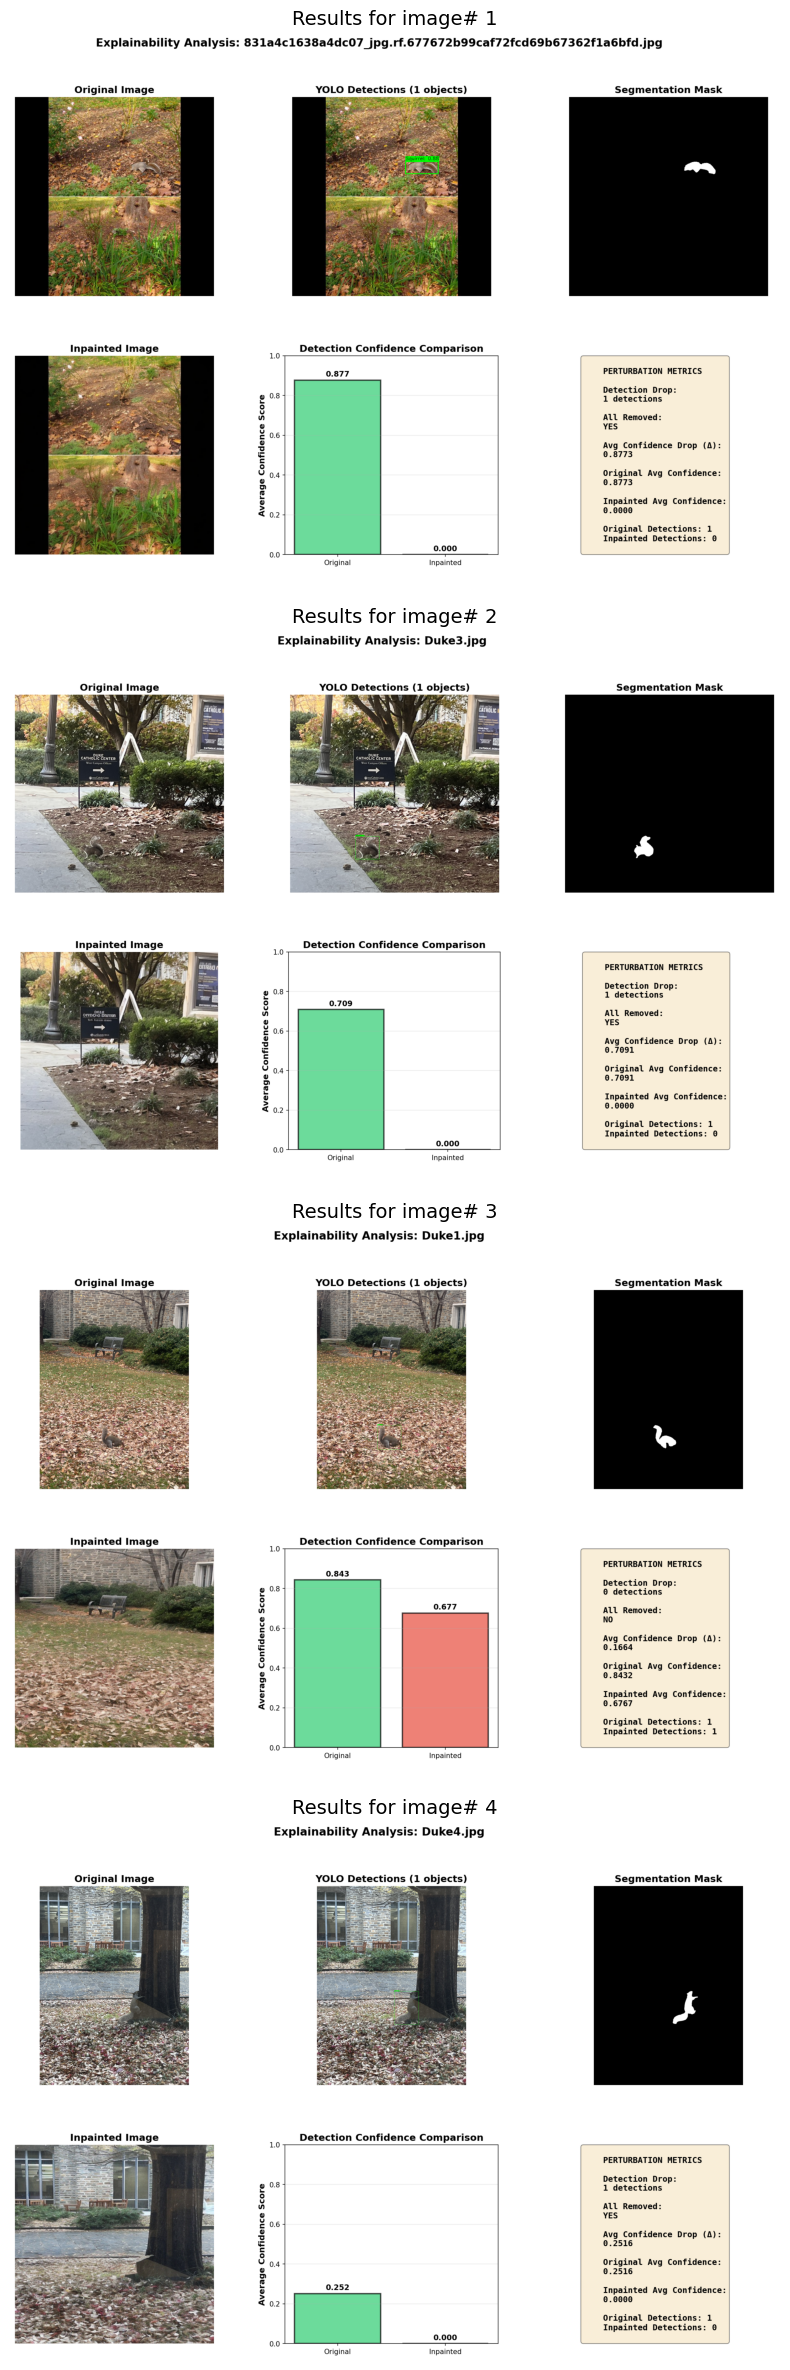

In [16]:
import os
import matplotlib.pyplot as plt

individual_dir = os.path.join(VISUALS_DIR, "individual")

# List of target visualization names
target_names = [
    "831a4c1638a4dc07_jpg.rf.677672b99caf72fcd69b67362f1a6bfd_visualization",
    "Duke3_visualization",
    "Duke1_visualization",
    "Duke4_visualization",
]

# Collect matching files (with .png extension)
selected_files = []
for name in target_names:
    # Allow .png or .jpg (in case)
    for ext in [".png", ".jpg", ".jpeg"]:
        fname = name + ext
        fpath = os.path.join(individual_dir, fname)
        if os.path.exists(fpath):
            selected_files.append(fpath)
            break  # Stop once found the correct extension

if not selected_files:
    print("None of the target visualization files found.")
else:
    # Create vertical layout
    fig, axes = plt.subplots(
        len(selected_files), 1, figsize=(8, 6 * len(selected_files))
    )

    if len(selected_files) == 1:
        axes = [axes]

    for i, fpath in enumerate(selected_files):
        img = plt.imread(fpath)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Results for image# {i+1}", fontsize=14)

    plt.tight_layout()
    plt.show()